In [125]:
import numpy as np
from PIL import Image
import subprocess
from typing import List
from tqdm.auto import tqdm

In [2]:
data = np.load('/kaggle/input/rag-test/test.npz')
images = data['photo']
conc = data['conc']
labels = data['labels']

In [3]:
from huggingface_hub import login
login()

In [5]:
from transformers import AutoProcessor, SiglipVisionModel
import torch

model_id = "google/medsiglip-448"
processor = AutoProcessor.from_pretrained(model_id)
model = SiglipVisionModel.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device).eval()
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

In [117]:
!apt-get update -qq && apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh
subprocess.Popen("ollama serve > /dev/null 2>&1", shell=True)
!ollama pull gemma3:27b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%#####################################################     96.4%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling e796792eba26:   0% ▕                  ▏ 3.1 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   0% ▕                  ▏  70 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   1% ▕                  ▏ 124 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   1% ▕                  ▏ 158 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   1% ▕                  ▏ 217 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   2% ▕                  ▏ 267 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   2% ▕                  ▏ 289 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   2% ▕                  ▏ 326 MB/ 17 GB                  pulling manifest 
pulling e796792eba26:   2% ▕                  ▏ 373 MB/ 17 GB            

In [12]:
pip install langchain langchain-community langchain-ollama chromadb pandas sentence-transformers

INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-ollama to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 108.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [83]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import Chroma
from langchain.schema import Document

import chromadb

In [141]:
llm = ChatOllama(
    model="gemma3:27b",
    temperature=0.2,
    num_ctx=8192 * 2,
    base_url="http://127.0.0.1:11434",
)

In [100]:
DB_PATH = "/kaggle/working/chroma_db"
COLLECTION_NAME = "xray"

native_client = chromadb.PersistentClient(DB_PATH)

vectorstore = Chroma(
    client=native_client,
    collection_name=COLLECTION_NAME,
)
retriever = vectorstore.as_retriever(
    search_kwargs={"k": 5}
)


Успех! Документов в базе: 8000


In [142]:
def retriever_func(query_vector, k=5):
    results = vectorstore._collection.query(
        query_embeddings=[query_vector],
        n_results=k,
        include=["metadatas", "distances"]
    )
    
    docs = []
    for meta, dist in zip(results["metadatas"][0], results["distances"][0]):
        conclusion = meta.get("conclusion", "")
        if not conclusion:
            conclusion = "The conclusion is missing from the metadata"
            
        doc = Document(
            page_content=conclusion,
            metadata={
                "source": "chroma_metadata",
                "distance": dist,
                "similarity": 1 - dist if dist is not None else 0.0
            }
        )
        docs.append(doc)
    
    return docs

In [143]:
def get_image_embedding(image_path: str) -> List[float]:
    try:
        img = Image.fromarray(image_path).convert("RGB")
        inputs = processor(images=img, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            emb = outputs.pooler_output
            emb = emb / emb.norm(dim=-1, keepdim=True)
        
        return emb[0].cpu().float().numpy().tolist()
    except Exception as e:
        print(f"Error {image_path}: {e}")
        return None

In [156]:
def ask_about_photo(photo_path: str, question: str = ""):
    emb = get_image_embedding(photo_path)

    retrieved_docs = retriever_func(emb, k=7)

    context_str = "\n\n".join(
        f"[Similarity: {doc.metadata['similarity']:.4f}]\n"
        f"{doc.page_content}"

        for doc in retrieved_docs
    )

    prompt = ChatPromptTemplate.from_template(
        """You are an experienced radiologist with many years of experience in diagnosing diseases based on X-rays and clinical data.

Your task is to analyze the provided context with similar cases from the database (conclusions of other radiologists), sorted in descending order of similarity with the current case. Based ONLY on this context, answer the user's question about a possible disease or diagnosis.

Basic rules:
- Rely ONLY on the context provided. Do NOT use external knowledge.
- Extract diseases/diagnoses from EACH report in the context.
- Count how many reports mention each disease (exact matches or very close synonyms).
- Give preference ONLY to diseases that appear FREQUENTLY: a disease must be mentioned in AT LEAST 5 reports . Ignore rare mentions (1-2 reports).
- If no disease meets this frequency threshold and is likely based on the top similar reports, conclude "none".
- Be confident: only select diseases where the context strongly supports them through repetition across multiple reports.
- Limit your final answer to 2-3 diseases MAXIMUM, and for each).
- Do NOT write explanations, reports, or extra text—only the disease names, or "none".

Step-by-step reasoning (think before answering):
1. List all reports from the context (there may be up to 6 or more).
2. For each report, extract the main disease/diagnosis mentioned.
3. Count the frequency of each unique disease across all reports.
4. Filter: keep only those with frequency >=5.
5. Sort by frequency descending, then by similarity order (prefer top reports).
6. If none qualify, output "none".

Similar conclusions (in descending order of similarity to the current case):
{context}

User's question: {question}

Your answer:"""
    )

    chain = (
        {"context": lambda x: context_str, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    answer = chain.invoke(question)
    return answer

In [162]:
pred = []
for i in tqdm(images):
    response = ask_about_photo(i, "Are there any pathologies?")
    print(response)
    pred.append(response)
    

  0%|          | 0/300 [00:00<?, ?it/s]

none
none
cardiomegaly, atelectasis, pulmonary oedema
none
COPD, Hyperinflated lungs, No acute cardiopulmonary process.
none
No acute cardiopulmonary process

atelectasis, pleural effusion, pneumonia
Pleural thickening, Atelectasis
atelectasis
none

cardiomegaly, atelectasis, hiatal hernia
none
none
none
cardiomegaly, pneumonia, pneumothorax
No acute cardiopulmonary process
Small left pleural effusion
none
Cardiomegaly, Pulmonary oedema.
pneumonia, interstitial lung disease, consolidation
none
none
none
none
none
none
cardiomegaly, atelectasis, pneumothorax
pneumothorax, pneumonia, effusion
pneumonia, pleural effusion
none
none
Pneumonia, Atelectasis, Degenerative changes
No acute cardiopulmonary process
COPD, pulmonary hypertension, cardiomegaly
pleural effusion, cardiomegaly, atelectasis
cardiomegaly, pleural effusion, pulmonary oedema
none
cardiomegaly, pulmonary oedema, atelectasis
none
none

none
Atelectasis
Pleural effusion
Pneumothorax
cardiomegaly, pneumonia, consolidation

non

In [131]:
def response(conc):
    return llm.invoke(
        f"for this report, determine which disease, if there is none, write None,your answer is only the name of the disease.. REPORT: {conc}")

In [134]:
true = []

In [169]:
subprocess.Popen("ollama serve > /dev/null 2>&1", shell=True)

<Popen: returncode: None args: 'ollama serve > /dev/null 2>&1'>

In [137]:
for i in tqdm(conc):
    res = response(i)
    print(res.content)
    true.append(res.content)

  0%|          | 0/300 [00:00<?, ?it/s]

None
None
None
hyperinflation
None
Pneumonia
Atelectasis
Pneumonia
None
None
Pneumonia
None
None

None
Pneumonia
hyperinflation
Pneumonia
None
Pericardial effusion
None
None
None
None

None
Cardiomegaly
Pneumonia
Chronic obstructive lung disease
None
COPD
Atelectasis
None
Scoliosis
Pneumonia
Cardiomegaly
None
Chronic lung disease
Metastatic disease
None
None
Atelectasis
None
None

None
None

None
None
Pneumonia
Pneumothorax
Subcutaneous emphysema
None

Emphysema
None
None

None
Congestive heart failure
Pleural effusion
Pleural effusion
None
None
Pneumonia
Pulmonary edema
None
Pneumonia
None
None
None
None
None
Pneumonia
Pneumonia

None
None
Atelectasis
Pneumonia
Thoracic scoliosis
None

Pneumonia
None
Pneumonia
None
Pneumonia
Pleural thickening
cardiomegaly
None
None
None
Cardiomegaly
None
Pneumonia
None

None
Esophageal dilation
Atelectasis
None

None
None
Pneumonia
None

None
Consolidation
None
None
None
Pneumonia
Cardiomegaly
Pleural effusion

None

Atelectasis
None
None
None
None



In [166]:
def conf(t, p):
    prompt = f"""
    You are an expert in evaluating disease classification models.

You are given two strings:
TRUE: "true_label"
PRED: "predicted_label"

Your task is to determine which category this prediction/reality pair belongs to.

Rules (very important):
- Consider diagnoses to be the same if they semantically mean the same disease (even if they are written differently, in different languages, with typos, abbreviations, or synonyms).
- Ignore minor differences in wording ("pneumonia" == "pneumonia", "flu" =="influenza", "acute respiratory viral infections"== "flu-like illness").
- If there are several comma-separated / and /+ diagnoses in TRUE or PRED, then this is considered a multi—label match if the main diseases match in meaning.

Answer ONLY one of the four options (just like that, without unnecessary words):

TP ← true positive (there is a disease and the model found it)
FP ← false positive (the model said there is no disease)
FN ← false negative (there is a disease, the model missed it)
TN ← true negative (there is nothing and the model did not say anything)

Examples:
TRUE: pneumonia PRED: pneumonia → TP
TRUE: healthy PRED: healthy → TN
TRUE: asthma PRED: no diagnosis → FN
TRUE: no diseases PRED: bronchitis → FP
TRUE: flu, ARVI PRED: influenza → TP
TRUE: COVID-19 PRED: pneumonia → FP
TRUE: nothing PRED: nothing → TN

TRUE: {t}
PRED: {p}

Category:
"""
    return llm.invoke(prompt)

In [172]:
conf_values = {'TN\n':0, 'FP\n':0, 'FN\n':0, 'TP\n':0}
for t, p in zip(true, pred):
    res = conf(t, p)
    print(f'{res.content=} {t=} {p=}')
    conf_values[res.content]+=1


res.content='TN\n' t='None' p='none'
res.content='TN\n' t='None' p='none'
res.content='FP\n' t='None' p='cardiomegaly, atelectasis, pulmonary oedema'
res.content='FN\n' t='hyperinflation' p='none'
res.content='TN\n' t='None' p='COPD, Hyperinflated lungs, No acute cardiopulmonary process.'
res.content='FN\n' t='Pneumonia' p='none'
res.content='FN\n' t='Atelectasis' p='No acute cardiopulmonary process\n'
res.content='TP\n' t='Pneumonia' p='atelectasis, pleural effusion, pneumonia'
res.content='FP\n' t='None' p='Pleural thickening, Atelectasis'
res.content='FP\n' t='None' p='atelectasis\nnone\n'
res.content='FP\n' t='Pneumonia' p='cardiomegaly, atelectasis, hiatal hernia'
res.content='TN\n' t='None' p='none'
res.content='TN\n' t='None\n' p='none'
res.content='TN\n' t='None' p='none'
res.content='TP\n' t='Pneumonia' p='cardiomegaly, pneumonia, pneumothorax'
res.content='TN\n' t='hyperinflation' p='No acute cardiopulmonary process\nSmall left pleural effusion\nnone'
res.content='FP\n' t='Pn

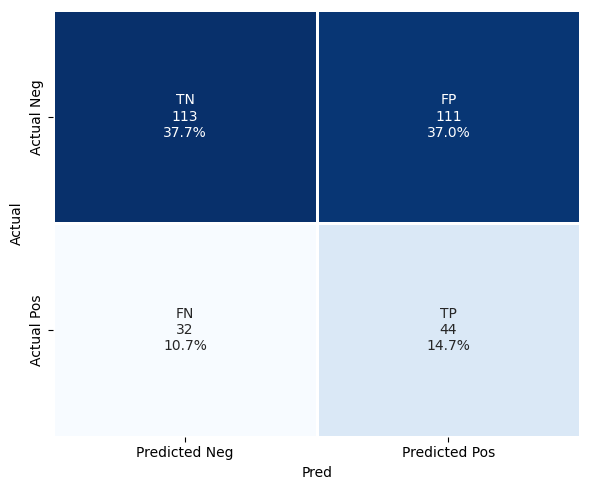

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

TP, TN, FP, FN = conf_values['TP\n'], conf_values['TN\n'], conf_values['FP\n'], conf_values['FN\n']

cm = np.array([[TN, FP],
               [FN, TP]])
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = [f"{v}" for v in [TN, FP, FN, TP]]
group_percent = [f"{v/sum(cm.flatten())*100:.1f}%" for v in [TN, FP, FN, TP]]

labels = [f"{name}\n{count}\n{perc}" for name, count, perc in zip(group_names, group_counts, group_percent)]
labels = np.array(labels).reshape(2, 2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", cbar=False,
            xticklabels=["Predicted Neg", "Predicted Pos"],
            yticklabels=["Actual Neg", "Actual Pos"],
            linewidths=1, linecolor="white")

plt.xlabel("Pred")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Precision (P) = TP / (TP + FP)

Recall (R)    = TP / (TP + FN)

F1-score      = 2 * (P * R) / (P + R)

In [178]:
P = TP/(TP+FP)
R = TP/(TP+FN)
f1 = 2*(P*R)/(P+R)
print(f"Precision = {P}\nRecall = {R}\nF1-Score = {f1}")

Precision = 0.2838709677419355
Recall = 0.5789473684210527
F1-Score = 0.38095238095238093
